In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### The pandas `.concat( )`  method is used to concatenate two dataframes based on shared column names
- we will create two dataframes and then concatenate them
- this would be useful if you had, for example, two different years of data with the same columns that you want to explore together; in a case like this, you would want to add a year column before joining them


In [2]:
data1 = { 'Col1' : [1,2,3],
         'Col2' : [4,5,6],
         'Col3' : [7,8,9]}
data2 = { 'Col1' : [4,5,6],
         'Col2' : [7,8,9],
         'Col3' : [1,2,3]}

In [3]:
df_2018 = pd.DataFrame(data1)
df_2019 = pd.DataFrame(data2)

In [4]:
print('df_2018')
print(df_2018)
print('=================')
print('df_2019')
print(df_2019)

df_2018
   Col1  Col2  Col3
0     1     4     7
1     2     5     8
2     3     6     9
df_2019
   Col1  Col2  Col3
0     4     7     1
1     5     8     2
2     6     9     3


#### Before we concatenate `df_2018` and `df_2019` we need to add a column for the year

In [5]:
df_2018['year'] = '2018'
df_2019['year'] = '2019'

In [6]:
concat_data = pd.concat([df_2018, df_2019])
print(concat_data)

## Notice that the index repeats itself

   Col1  Col2  Col3  year
0     1     4     7  2018
1     2     5     8  2018
2     3     6     9  2018
0     4     7     1  2019
1     5     8     2  2019
2     6     9     3  2019


### The `reset_index( )` method will change these to a 0-based incrementing index
- add the `drop = True` argument to prevent saving the current index as a column


In [7]:
concat_data = concat_data.reset_index(drop = True)
print(concat_data)

   Col1  Col2  Col3  year
0     1     4     7  2018
1     2     5     8  2018
2     3     6     9  2018
3     4     7     1  2019
4     5     8     2  2019
5     6     9     3  2019


### Another method for combining data is  `merge( )`
- First we'll read in the schools data again
- And we'll read in the school indicator scores


In [8]:
schools = pd.read_csv('../data/schools_clean.csv')
schools.head(2)

,level,name,zipcode,grade_k,grade_1,grade_2,grade_3,grade_4,grade_5,grade_6,...,hisp,p_islander,white,male,female,econ_disadv,disabled,limited_eng,lat,lng
0,Elementary School,A. Z. Kelley Elementary,37013,153.0,145.0,149.0,180.0,184.0,NaN,NaN,...,206,1.0,212.0,431,421,261,75.0,298.0,36.021817,-86.658848
1,Elementary School,Alex Green Elementary,37189,42.0,50.0,44.0,38.0,24.0,NaN,NaN,...,29,1.0,21.0,115,119,153,21.0,25.0,36.252961,-86.832229


In [9]:
indicators = pd.read_csv('../data/school_indicator_scores_suppressed.csv')
indicators.head(2)

,system,system_name,school,school_name,pool,designation_ineligible,subgroup,score_achievement,score_growth,score_absenteeism,score_grad,score_ready_grad,score_elpa
0,10,Anderson County,2,Anderson County High School,HS,0.0,All Students,3.0,4.0,4.0,4.0,4.0,NaN
1,10,Anderson County,2,Anderson County High School,HS,0.0,American Indian or Alaska Native,NaN,NaN,NaN,NaN,NaN,NaN


### Before we merge, we need to decide 
- which columns to keep from each dataframe  
- what _type_ of merge we want

#### Let's say we want to look at the effect of poverty on school indicators
- From the schools data, we need name, total number of students, and total who are economically disadvantaged
    - we need to create a column for the total number of students before we can subset the schools dataframe
- From the school indicators dataframe, we need school name, and the six *score* columns
    - filtering the dataframe first so that we only look at Davidson County schools is a good idea
    - we also want to filter in order to keep only the rows where subgroup is "All Students"


In [16]:
schools['total_students'] = schools.male + schools.female
schools.head(2)

,level,name,zipcode,grade_k,grade_1,grade_2,grade_3,grade_4,grade_5,grade_6,...,p_islander,white,male,female,econ_disadv,disabled,limited_eng,lat,lng,total_students
0,Elementary School,A. Z. Kelley Elementary,37013,153.0,145.0,149.0,180.0,184.0,NaN,NaN,...,1.0,212.0,431,421,261,75.0,298.0,36.021817,-86.658848,852
1,Elementary School,Alex Green Elementary,37189,42.0,50.0,44.0,38.0,24.0,NaN,NaN,...,1.0,21.0,115,119,153,21.0,25.0,36.252961,-86.832229,234


In [17]:
schools_subset = schools[['name', 'total_students', 'econ_disadv']]

In [18]:
indicators = indicators.loc[(indicators.system_name == 'Davidson County') & (indicators.subgroup == 'All Students')]
indicators.shape

(155, 13)

In [19]:
indicators_subset = indicators[['school_name', 'score_achievement', 'score_growth', 'score_absenteeism',
                                'score_grad', 'score_ready_grad', 'score_elpa']]

In [20]:
print('schools subset: ', schools_subset.shape)
print('indicators subset: ', indicators_subset.shape)

schools subset:  (167, 3)
indicators subset:  (155, 7)


### There are 12 more rows in the schools_subset data than there are in the indicators_subset
- We want data that matches to **both** datasets 
![pandas merge types](../images/pandas_merge_types.png)
- So we want an inner join (which is the default)

In [21]:
schools_with_scores = pd.merge(schools_subset, indicators_subset, left_on = 'name', right_on = 'school_name', how = 'inner')
schools_with_scores.head(3)

,name,total_students,econ_disadv,school_name,score_achievement,score_growth,score_absenteeism,score_grad,score_ready_grad,score_elpa
0,A. Z. Kelley Elementary,852,261,A. Z. Kelley Elementary,2.0,2.0,4.0,NaN,NaN,3.0
1,Alex Green Elementary,234,153,Alex Green Elementary,2.0,2.0,4.0,NaN,NaN,2.0
2,Amqui Elementary,458,246,Amqui Elementary,2.0,4.0,4.0,NaN,NaN,4.0


### We can drop one of the school name columns and calculate the percentage of students from each school who are economically disadvantaged.

In [22]:
schools_with_scores = schools_with_scores.drop(columns = 'school_name')

In [23]:
schools_with_scores['pct_econ_disadv'] = schools_with_scores.econ_disadv / schools_with_scores.total_students
schools_with_scores.head()

,name,total_students,econ_disadv,score_achievement,score_growth,score_absenteeism,score_grad,score_ready_grad,score_elpa,pct_econ_disadv
0,A. Z. Kelley Elementary,852,261,2.0,2.0,4.0,NaN,NaN,3.0,0.306338
1,Alex Green Elementary,234,153,2.0,2.0,4.0,NaN,NaN,2.0,0.653846
2,Amqui Elementary,458,246,2.0,4.0,4.0,NaN,NaN,4.0,0.537118
3,Andrew Jackson Elementary,496,122,3.0,4.0,4.0,NaN,NaN,2.0,0.245968
4,Antioch High School,1915,622,1.0,0.0,4.0,2.0,3.0,0.0,0.324804


### We'll take a quick peak at the relationship between the percentage of students who are economically disadvantaged and the achievement score  for schools and then save this dataset for further exploration

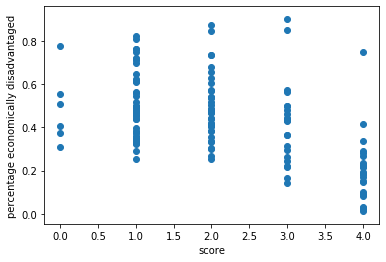

In [26]:
plt.scatter('score_achievement', 'pct_econ_disadv', data = schools_with_scores)
plt.xlabel('score')
plt.ylabel('percentage economically disadvantaged');

In [27]:
schools_with_scores.to_csv('../data/schools_with_scores.csv', index = False)